In [6]:
# Importing modules
import pandas as pd
import os
import string


# Read data into papers
papers = pd.read_csv('dataset/filtere_dice_jobs_dataset.csv')
papers['employmenttype_jobstatus'] = papers['employmenttype_jobstatus'].fillna('None')


In [7]:
data = []
data.append(papers['employmenttype_jobstatus'].values.tolist())
res = []
for i in range (0,papers.shape[0]):
  res.append(data[0][i])


In [8]:
def text_lowercase(text):
    return text.lower()
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [9]:
results = []
for i in range(0,papers.shape[0]):
    lower_punc = text_lowercase(res[i]).replace(',','')
    results.append(lower_punc)

In [10]:
# Print out the first rows of papers
papers['paper_text_processed'] =  results

In [12]:
papers['fulldesc'] = (papers.paper_text_processed+" "+papers.jobtitle +" "+papers.skills).astype(object)

# Print head
papers.head(2)

,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id,paper_text_processed,fulldesc
0,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7,full time,full time DevOps Engineer Configuration Manage...
1,https://www.dice.com/jobs/detail/Network-Engin...,Noble1,"Full Time, Direct Hire",Network Engineer Job Description A Network Eng...,Dice Id : 90884761,"Atlanta, GA",Network Engineer,1 hour ago,Telecommuting not available|Travel not required,NaN,"Cisco, DNS, HTTP, Networking, Network Engineer...",e7e326053c586bd94e59f1fd74de4a1b,full time direct hire,"full time direct hire Network Engineer Cisco, ..."


In [13]:
# Load the regular expression library
import re

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['fulldesc'].map(lambda x: x.lower())

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))



# Print out the first rows of papers
papers['paper_text_processed'].head()

0    full time devops engineer configuration manage...
1    full time direct hire network engineer cisco  ...
2    full time direct placement front end developer...
3    contract w  contract project manager mobile de...
4    contract w  contract business systems analyst ...
Name: paper_text_processed, dtype: object

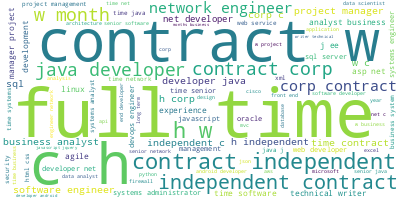

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [15]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','experience'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['full', 'time', 'devops', 'engineer', 'configuration', 'management', 'developer', 'linux', 'management', 'process', 'engineering', 'vmware']


[nltk_data] Downloading package stopwords to /home/sid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1)]


In [17]:
id2word

In [18]:

from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [19]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sid/.local/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/home/sid/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/lib/python3/dist-packages/past/builtins/misc.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.046312  0.012491       1        1  23.703733
3      0.109040 -0.019038       2        1  18.745225
2     -0.024842 -0.028105       3        1  10.941022
4     -0.089088  0.015963       4        1   9.086166
8     -0.044645 -0.080810       5        1   7.692005
0      0.102428  0.031154       6        1   7.052969
7      0.064209  0.038503       7        1   6.676222
6     -0.013629  0.074127       8        1   5.652775
9     -0.074382  0.044975       9        1   5.321795
1      0.017221 -0.089260      10        1   5.128088, topic_info=            Term         Freq        Total Category  logprob  loglift
1      developer   671.000000   671.000000  Default  30.0000  30.0000
56          java   551.000000   551.000000  Default  29.0000  29.0000
29      contract  1121.000000  1121.000000  Default  28.0000  28.0000
44          corp   748.000000   748.000000  Default  27.0000  27.0000
40           net   341.000000   341.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
146          asp     6.033567   101.100162  Topic10  -5.2283   0.1517
55   independent     8.012531   436.818013  Topic10  -4.9446  -1.0281
41      software     7.388712   333.922332  Topic10  -5.0257  -0.8405
37      business     6.967507   303.791411  Topic10  -5.0844  -0.8046
18      security     5.454699    77.873908  Topic10  -5.3292   0.3118

[774 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1532      8  0.516808   abode
905       7  0.631527     aci
443       8  0.516800  action
1333     10  0.577561   acute
1047      3  0.508430   adapt
...     ...       ...     ...
257       7  0.095928   years
257       8  0.019186   years
257       9  0.038371   years
257      10  0.076743   years
1504      5  0.478037  zigbee

[1560 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 3, 5, 9, 1, 8, 7, 10, 2])

In [25]:
def tokenization_report(bow, article_number):
    article_tokens = bow[article_number]
    sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True)
    for i in range(len(bow[article_number])):
        print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens[i][0], 
                                                         id2word[sorted_tokens[i][0]], 
                                                         sorted_tokens[i][1]))
tokenization_report(corpus, 1562)

Word 3 ("engineer") appears 1 time(s).
Word 5 ("full") appears 1 time(s).
Word 9 ("time") appears 1 time(s).
Word 16 ("network") appears 1 time(s).
Word 21 ("wireless") appears 1 time(s).
Word 459 ("firewalls") appears 1 time(s).
Word 578 ("routing") appears 1 time(s).
Word 585 ("fte") appears 1 time(s).
Word 612 ("load") appears 1 time(s).
Word 662 ("switching") appears 1 time(s).
Word 1611 ("balancing") appears 1 time(s).
Word 1941 ("cable") appears 1 time(s).
Word 1942 ("modems") appears 1 time(s).


1563